In [46]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV

# set random state to use throughout
rs = 25

In [2]:
# import data and format it
data = pd.read_csv('../Data/gss_subset_cleaned.csv')
data = data[data['year']> 2005]
# drop highly correlated columns and unusable columns identified in earlier analysis
data.drop(['paeduc', 'maeduc', 'speduc', 'income', 'satjob', 'goodlife', 
           'health', 'year', 'hompop', 'earnrs'], axis=1, inplace=True)
# drop less important features from first run-through of RF
data.drop(['babies', 'preteen', 'teens', 'divorce', 'dwelling', 'sex'], axis=1, inplace=True)
# drop features that are non-demographic (ie would need to be collected in interview)
data.drop(['satfin', 'weekswrk', 'polviews'], axis=1, inplace=True)
data.dropna(inplace=True)

In [3]:
# set X and y
X = pd.get_dummies(data.drop('happy', axis=1), drop_first=True)
y = data['happy'] > 1

In [4]:
# look at % in each class
y.value_counts()/y.count()

True     0.85787
False    0.14213
Name: happy, dtype: float64

In [5]:
# do train_test split
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(),
        stratify = y, test_size=0.2, random_state=rs)

In [6]:
# instantiate Random Forest
rf = RandomForestClassifier(random_state=rs, n_jobs=-1)

In [7]:
# define param grid for gridsearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [12,15,18],
    'n_estimators': [12,15,18],
    'min_samples_split': [40,50,60],
    'min_samples_leaf': [5,10,20],
    'max_features': [5,10,'auto']
}

In [8]:
# instantiate gridsearch for random forest
gsrf = GridSearchCV(rf, param_grid, n_jobs=-1)

In [9]:
gsrf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [5, 10, 20], 'n_estimators': [12, 15, 18], 'max_features': [5, 10, 'auto'], 'criterion': ['gini', 'entropy'], 'min_samples_split': [40, 50, 60], 'max_depth': [12, 15, 18]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [10]:
gsrf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features=5, max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [11]:
gsrf.score(X_test, y_test)

0.85701754385964912

In [12]:
gsrf_proba = gsrf.predict_proba(X_test)
gsrf_pred = gsrf_proba[:,1] > 0.85

In [13]:
print classification_report(y_test, gsrf_pred)
print confusion_matrix(y_test, gsrf_pred)

             precision    recall  f1-score   support

      False       0.22      0.63      0.33       324
       True       0.91      0.63      0.75      1956

avg / total       0.81      0.63      0.69      2280

[[ 203  121]
 [ 721 1235]]


In [14]:
features = X.columns
importances = gsrf.best_estimator_.feature_importances_
feat_importances = pd.DataFrame(index=features, columns = ['importance'])
feat_importances['importance'] = importances

In [15]:
feat_importances.sort_values(by='importance', ascending = False)

,importance
educ,0.202975
age,0.184281
marital_married,0.166036
sibs,0.117871
dwelown_owns,0.068964
childs,0.065303
dwelown_rents,0.046786
adults,0.040655
hhrace_black,0.026539
marital_never_married,0.026528


In [38]:
modelprobs = pd.DataFrame()
modelprobs['Model_Prob_Happy'] = gsrf_proba[:,1]
modelprobs['Unhappy_True'] = y_test == False
modelprobs.sort_values(by='Model_Prob_Happy', axis=0, inplace=True)

In [39]:
modelprobs.head()

,Model_Prob_Happy,Unhappy_True
1251,0.462552,True
1529,0.469831,False
1966,0.480090,False
2210,0.483177,False
1061,0.487440,False


In [47]:
modelprobs['portion_unhappy_captured'] = np.cumsum(modelprobs['Unhappy_True'])/np.sum(modelprobs['Unhappy_True'])
modelprobs['portion_happy_mislabeled'] = np.cumsum(1-modelprobs['Unhappy_True'])/np.sum(1-modelprobs['Unhappy_True'])

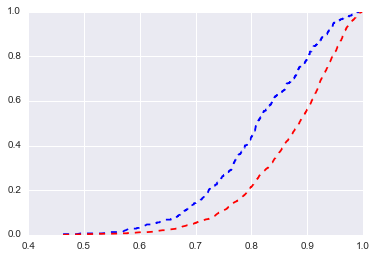

In [49]:
x = modelprobs['Model_Prob_Happy']
y1 = modelprobs['portion_unhappy_captured']
y2 = modelprobs['portion_happy_mislabeled']
plt.plot(x, y1, 'b--', x, y2, 'r--')